## Probabilistic Forecasting with Fuzzy Time Series

- pyFTS library was chosen to study this model
- Probabilistic Weighted Fuzzy Time Series(pwfts) will be compared with High-Order Fuzzy Time Series(hofts) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import time
from datetime import datetime

from pyFTS.common import Util
from pyFTS.benchmarks import Measures
from pyFTS.benchmarks import benchmarks
from sklearn.metrics import r2_score
from pyFTS.partitioners import Grid,  Entropy #Huarng
from pyFTS.models import hofts
from pyFTS.common import Membership

import warnings
warnings.filterwarnings('ignore')

/Users/ZachAnaz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/ZachAnaz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
water_level = pd.read_csv('cleaned-JPS WL data-kkrai.csv')  
water_level.head(5)

,Date,Stage m
0,2010-01-01,17.06
1,2010-02-01,17.00
2,2010-03-01,17.31
3,2010-04-01,18.60
4,2010-05-01,18.15


In [3]:
# set date as index
water_level.set_index('Date', inplace=True)
water_level

,Stage m
Date,
2010-01-01,17.06
2010-02-01,17.00
2010-03-01,17.31
2010-04-01,18.60
2010-05-01,18.15
...,...
2019-07-27,15.56
2019-07-28,15.86
2019-07-29,15.97


In [4]:
water_level.describe()

,Stage m
count,3499.000000
mean,16.638231
std,1.582909
min,1.680000
25%,15.830000
50%,16.380000
75%,17.120000
max,33.930000


In [5]:
#plot the data
train_uv = water_level['Stage m'].values[:2786]
test_uv = water_level['Stage m'].values[2786:]

water_level.head()

models = []

Split train data (80%) and test data (20%)

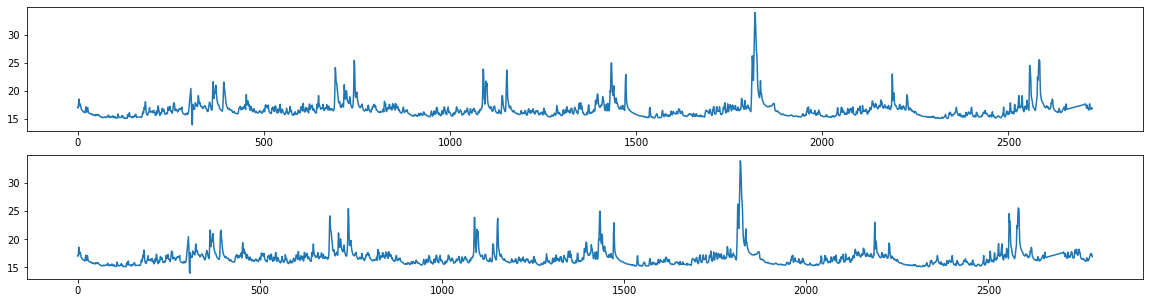

In [6]:
#train data 80%
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=[20,5])

ax[0].plot(train_uv[:2726])
ax[1].plot(train_uv)

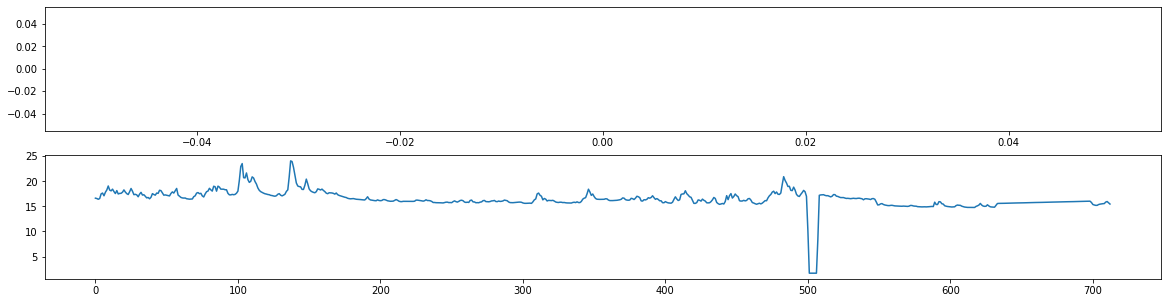

In [7]:
#plot the test data 80%
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=[20,5])

ax[0].plot(test_uv[2726:])
ax[1].plot(test_uv)

Text(0.5, 0, 'LAG')

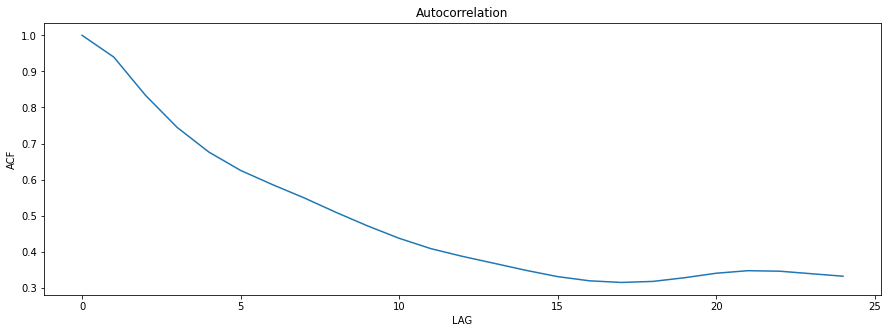

In [8]:
#autocorrelation factor(ACF)
from statsmodels.tsa.stattools import acf

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,5])

ax.plot(acf(train_uv,nlags=24))
ax.set_title("Autocorrelation")
ax.set_ylabel("ACF")
ax.set_xlabel("LAG")

## Partitioning

In [9]:
# partitioning for univariate model
from itertools import product

levels = ['WL']
sublevels = [str(k) for k in np.arange(0,50)]
names = []
for combination in product(*[levels, sublevels]):
  names.append(combination[0]+combination[1])
  
print(names)

['WL0', 'WL1', 'WL2', 'WL3', 'WL4', 'WL5', 'WL6', 'WL7', 'WL8', 'WL9', 'WL10', 'WL11', 'WL12', 'WL13', 'WL14', 'WL15', 'WL16', 'WL17', 'WL18', 'WL19', 'WL20', 'WL21', 'WL22', 'WL23', 'WL24', 'WL25', 'WL26', 'WL27', 'WL28', 'WL29', 'WL30', 'WL31', 'WL32', 'WL33', 'WL34', 'WL35', 'WL36', 'WL37', 'WL38', 'WL39', 'WL40', 'WL41', 'WL42', 'WL43', 'WL44', 'WL45', 'WL46', 'WL47', 'WL48', 'WL49']


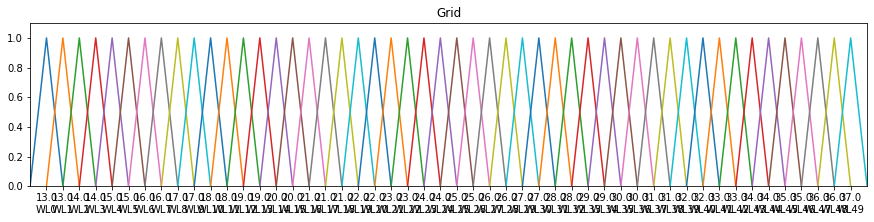

In [10]:
from pyFTS.partitioners import Grid

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=[15,3])

part = Grid.GridPartitioner(data=train_uv,npart=50, names=names)

part.plot(ax)

In [11]:
# show the values of the partitioned model
for p in part:
    print(p)

WL0: trimf([12.09636, 12.591000000000001, 13.085640000000001])
WL1: trimf([12.591000000000001, 13.085640000000001, 13.580280000000002])
WL2: trimf([13.085640000000001, 13.580280000000002, 14.074920000000002])
WL3: trimf([13.580280000000002, 14.074920000000002, 14.569560000000003])
WL4: trimf([14.074920000000002, 14.569560000000003, 15.064200000000003])
WL5: trimf([14.569560000000003, 15.064200000000003, 15.558840000000004])
WL6: trimf([15.064200000000003, 15.558840000000004, 16.053480000000004])
WL7: trimf([15.558840000000004, 16.053480000000004, 16.548120000000004])
WL8: trimf([16.053480000000004, 16.548120000000004, 17.042760000000005])
WL9: trimf([16.548120000000004, 17.042760000000005, 17.537400000000005])
WL10: trimf([17.042760000000005, 17.537400000000005, 18.032040000000006])
WL11: trimf([17.537400000000005, 18.032040000000006, 18.526680000000006])
WL12: trimf([18.032040000000006, 18.526680000000006, 19.021320000000006])
WL13: trimf([18.526680000000006, 19.021320000000006, 19.51

21 ns ± 0.862 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


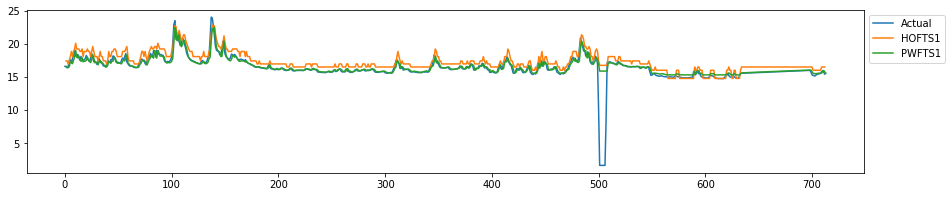

In [12]:
# train the model

from pyFTS.models import hofts,pwfts

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15,3])


ax.plot(test_uv[:2726], label='Actual')
%timeit rows = []
for method in [hofts.HighOrderFTS,pwfts.ProbabilisticWeightedFTS]:
  for order in [1]:
    model = method(partitioner=part, order=order)

    model.shortname += str(order)

    model.fit(train_uv)

    forecasts = model.predict(test_uv)

    for k in np.arange(order):
      forecasts.insert(0,None)

    ax.plot(forecasts[:2726], label=model.shortname)

    models.append(model.shortname)

    Util.persist_obj(model, model.shortname)

    del(model)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))

In [13]:
#calculate RMSE for the two models
rows = []
for file in models:
  try:
    model = Util.load_obj(file)

    row = [model.shortname, model.order,len(model)]

    if model.is_multivariate:
      rmse,_,_ = Measures.get_point_statistics(test_mv, model)
      row.append(rmse)
    else:
      rmse,_,_ = Measures.get_point_statistics(test_uv, model)
      row.append(rmse)

    rows.append(row)
  except:
    pass
pd.DataFrame(rows,columns=["Model","Order","Size","RMSE"]).sort_values(["RMSE", "Size"])

,Model,Order,Size,RMSE
1,PWFTS1,1,38,1.42
0,HOFTS1,1,38,1.69
